<h3>VVI (Reusable Code)</h3>

In [1]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [2]:
load_dotenv()

True

In [3]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
search_tool=TavilySearchResults(max_results=2)

In [6]:
tools=[search_tool]

In [8]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [9]:
# illustrations
llmLlama.invoke(input="Who is SRT?")

AIMessage(content='SRT can refer to different entities, but some of the most notable ones are:\n\n1. **Street Racing Technology (SRT)**: SRT is a performance division of FCA (Fiat Chrysler Automobiles), which is now part of Stellantis. It was established in 2004 to focus on creating high-performance vehicles. The division is known for its iconic models, such as the Dodge Challenger SRT Hellcat and the Dodge Charger SRT Hellcat. SRT is no longer a standalone brand but operates as a subsidiary of Dodge, focusing on creating high-performance vehicles.\n\n2. **Ram SRT**: Ram SRT is a high-performance version of the Ram 1500 pickup truck, which was introduced in 2019. It is powered by a 6.2-liter supercharged V8 engine, producing 702 horsepower.\n\n3. **SRT (Society for Research on Tilapia)**: SRT is a research organization that focuses on the biology and culture of tilapia fish.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 205, 'prompt_tokens': 40, 'total

In [10]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [11]:
# illustration
t=llm_with_tools.invoke(input="What's the temperature at Kharagpur now?")
t

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4vewwyn6e', 'function': {'arguments': '{"query":"Kharagpur current temperature"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 289, 'total_tokens': 312, 'completion_time': 0.034418824, 'prompt_time': 0.041738406, 'queue_time': 0.05056599, 'total_time': 0.07615723}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--32e107b6-30ad-44a8-8715-300befa6c385-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kharagpur current temperature'}, 'id': '4vewwyn6e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 289, 'output_tokens': 23, 'total_tokens': 312})

In [12]:
# illustration
search_tool.invoke(t.tool_calls[0]['args']['query'])

[{'title': 'Current Weather - Kharagpur, West Bengal - AccuWeather',
  'url': 'https://www.accuweather.com/en/in/kharagpur/191582/current-weather/191582',
  'content': 'Current Weather · 91°F Cloudy · RealFeel® 104°. Very Hot. RealFeel Guide. Very Hot. 101° to 107°. Caution advised. Danger of dehydration, heat stroke, heat',
  'score': 0.86713725},
 {'title': 'Kharagpur, West Bengal, India 14 day weather forecast',
  'url': 'https://www.timeanddate.com/weather/india/kharagpur/ext',
  'content': '| Sat Aug 9 |  | 89 / 83 °F | Passing showers. Overcast. | 93 °F | 12 mph | ↑ | 62% | 50% | 0.02" | 3 (Moderate) | 5:17 am | 6:16 pm |\n| Sun Aug 10 |  | 89 / 83 °F | Cloudy. | 92 °F | 11 mph | ↑ | 60% | 41% | 0.01" | 3 (Moderate) | 5:17 am | 6:16 pm |\n|  |  |  |  |  |  |  |  |  |  |  |  |  |\n| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |\n| \\ Updated Sunday, July 27, 2025 8:54:12 am Kharagpur time - Weather by CustomWeather, © 2025 | | | | | | | | | | | | | 

In [13]:
def agent(state:ChildState):
    state["messages"]=llm_with_tools.invoke(input=state["messages"])
    return state

In [14]:
def tools_router(state: ChildState):
    print(f"State prior to tool calling: {state}\n")
    last_message=state["messages"][-1]
    if (hasattr(last_message,"tool_calls")) and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return "end"

In [17]:
tool_node=ToolNode(tools=tools)

In [18]:
subGraph=StateGraph(state_schema=ChildState)

In [19]:
subGraph.add_node(node="agent",action=agent)

In [20]:
subGraph.add_node(node="tool_node", action=tool_node)

In [21]:
subGraph.add_conditional_edges(source="agent",path=tools_router,
                               path_map={"tool_node":"tool_node","end":END}
                              )

In [22]:
subGraph.add_edge(start_key="tool_node",end_key="agent")

In [23]:
subGraph.set_entry_point(key="agent")

In [24]:
search_app=subGraph.compile()

In [25]:
print(search_app.get_graph().print_ascii())

          +-----------+           
          | __start__ |           
          +-----------+           
                 *                
                 *                
                 *                
            +-------+             
            | agent |             
            +-------+.            
           **         ..          
         **             ..        
        *                 .       
+-----------+         +---------+ 
| tool_node |         | __end__ | 
+-----------+         +---------+ 
None


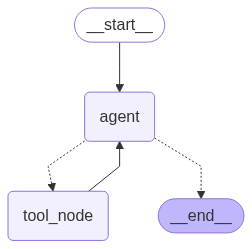

In [26]:
display(Image(data=search_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [27]:
response=search_app.invoke(input={"messages":"How is the weather in Chennai?"})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='b819527b-e887-475b-8dac-be1a397c664d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7kkx108z8', 'function': {'arguments': '{"query":"Chennai weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.03366499, 'prompt_time': 0.016915045, 'queue_time': 0.05591318499999999, 'total_time': 0.050580035}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9768509-03c7-40d4-93b3-eb23d5eea437-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather'}, 'id': '7kkx108z8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305})]}

Sta

In [28]:
response

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='b819527b-e887-475b-8dac-be1a397c664d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '7kkx108z8', 'function': {'arguments': '{"query":"Chennai weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.03366499, 'prompt_time': 0.016915045, 'queue_time': 0.05591318499999999, 'total_time': 0.050580035}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9768509-03c7-40d4-93b3-eb23d5eea437-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather'}, 'id': '7kkx108z8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolMessage(content='[{"title"

<h3>Shared Schema, direct embedding</h3>

In [29]:
class ParentState(TypedDict):
    messages:Annotated[list, add_messages]

In [30]:
# Create a parent graph
parent_graph=StateGraph(state_schema=ParentState)

In [31]:
# Add the subgraph as a node
parent_graph.add_node(node="search_agent",action=search_app)

In [32]:
# connect the flow
parent_graph.add_edge(start_key=START,end_key="search_agent")

In [33]:
# connect the flow
parent_graph.add_edge(start_key="search_agent",end_key=END)

In [34]:
# Compile the parent graph
parent_app=parent_graph.compile()

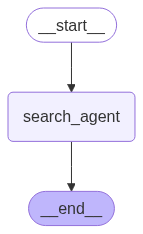

In [35]:
display(Image(data=parent_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [37]:
response=parent_app.invoke(input={"messages":"How is the weather in Kolkata?"})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='11dcc0c7-8f06-4bf6-9a58-4c2b5967b4be'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1szw8xyvq', 'function': {'arguments': '{"query":"Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.037495732, 'prompt_time': 0.020869387, 'queue_time': 0.324704318, 'total_time': 0.058365119}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--57388af7-ebfc-45b1-983c-24685583101a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': '1szw8xyvq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305})]}

State prio

In [38]:
response

{'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='11dcc0c7-8f06-4bf6-9a58-4c2b5967b4be'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1szw8xyvq', 'function': {'arguments': '{"query":"Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.037495732, 'prompt_time': 0.020869387, 'queue_time': 0.324704318, 'total_time': 0.058365119}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--57388af7-ebfc-45b1-983c-24685583101a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': '1szw8xyvq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolMessage(content='[{"title": "Kolk

<h3>Different Schema (Invoke with Transformation)</h3>

In [39]:
# define parent graph with a different scheme
class QueryState(TypedDict):
    query: str
    response: str

In [40]:
# Function to invoke a Subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to Subgraph schema
    subgraph_input={"messages":[state['query']]}
    # Invoke the subgraph
    subgraph_result=search_app.invoke(input=subgraph_input)

    state['response']=subgraph_result["messages"][-1].content
    return state

In [42]:
# Create a parent graph
parent_graph=StateGraph(state_schema=QueryState)

In [43]:
# Add transformation node that invokes subgraph
parent_graph.add_node(node="search_agent",action=search_agent)

In [44]:
# connect the flow
parent_graph.add_edge(start_key=START,end_key="search_agent")

In [45]:
# connect the flow
parent_graph.add_edge(start_key="search_agent",end_key=END)

In [46]:
# Compile the parent graph
parent_app=parent_graph.compile()

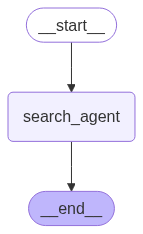

In [47]:
display(Image(data=parent_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [48]:
response=parent_app.invoke(input={"query":"How is the weather in Kolkata?","response":""})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='322d2d75-e073-438a-a335-eeac64fac482'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fs5v8y5w5', 'function': {'arguments': '{"query":"Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.033751404, 'prompt_time': 0.01840649, 'queue_time': 0.051867812, 'total_time': 0.052157894}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a1541a0e-1096-455a-a9e5-765c7d0977be-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': 'fs5v8y5w5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305})]}

State prior

In [49]:
response

{'query': 'How is the weather in Kolkata?',
 'response': 'The weather in Kolkata in July 2025 is expected to be hot and humid with temperatures ranging from 25°C to 35°C. There is a high chance of rainfall, with an average of 365 mm of precipitation throughout the month. The humidity is expected to be high, ranging from 60% to 90%. It is recommended to pack light and breathable clothing, as well as an umbrella or raincoat to protect against the rain.'}